In [1]:
# Required packages to run the script
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticke
import seaborn as sns

from matplotlib.colors import LogNorm
import math
import os
from scipy import sparse
from scipy.sparse.linalg import lsqr
import scipy.fftpack
import xlsxwriter
import importlib
import plotly.express as px
import plotly.graph_objects as go
import glob

import pickle

In [2]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, 's:\\131-DPE\\131.1-Temporaire\\131.1.1-Espace commun\\zone transfert temporaire\\ITESE Grenoble\\Stage Justine\\Code git\\wavelet_decomposition')

In [3]:
# Importing functions 
from utilities import import_excel, optimize_enr, format_load_data

from calc_translations import calculate_all_translations, calc_all_translations_justine
from wavelet_decomposition import compute_wavelet_coefficient_betas
from wavelet_decomposition import preplotprocessing
from wavelet_decomposition import reconstruct

from plots import plot_betas_heatmap
# from plots import plot_EPN
from calc_EPN import calc_epn
from miscelaneous_functions import create_directory

In [4]:
import numpy as np
import pickle as pkl
import os
from scipy import sparse
from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize

In [5]:
path_input_data = '../input_time_series/'
dpd = 24 # data per day in the time serie
dpy = 365 # data per year :  cut the leap years to 365 years

ndpd = 64 # new data per day for hourly data (for the interpolation)
signal_length = ndpd * dpy


In [6]:
countries = pd.read_csv('../countries_codes_and_coordinates_adapted.csv' , sep = ',', index_col = 0).index.to_list()
usa_states_codes = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'Californie',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Floride', 'GA': 'Géorgie',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
    'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiane', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri',
    'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
    'NM': 'Nouveau-Mexique', 'NY': 'New York', 'NC': 'Caroline du Nord', 'ND': 'Dakota du Nord', 'OH': 'Ohio',
    'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvanie', 'RI': 'Rhode Island', 'SC': 'Caroline du Sud',
    'SD': 'Dakota du Sud', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
    'VA': 'Virginie', 'WA': 'Washington', 'WV': 'Virginie-Occidentale', 'WI': 'Wisconsin', 'WY': 'Wyoming'
}
brazil_states_codes = [
    'AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG', 'MS', 
    'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR', 'RS', 'SC', 
    'SE', 'SP', 'TO'
]

canadian_province_codes = ['AB', 'BC', 'MB', 'NB', 'NL', 'NT', 'NS', 'NU', 'ON', 'PE', 'QC', 'SK', 'YT']

china_province_abbreviations = [
    "CN061", "CN031", "CN050", "CN033", "CN036", "CN053", "CN037", "CN021", "CN054", "CN062", "CN081", "CN063", 
    "CN011", "CN011", "CN015", "CN042", "CN034", "CN052", "CN064", "CN032", "CN065", "CN014", "CN043", "CN051", 
    "CN045", "CN022", "CN013", "CN012", "CN044", "CN035", "CN023", "CN041", "CN046"
]


australia_states_codes = ['NSW', 'QLD', 'SA','WA','VIC','TAS', 'NT', 'NSW','QLD', 'SA', 'WA','VIC','TAS','NT']

russia_states_codes = pd.read_excel('codes_russia.xlsx')['shapeISO'].to_list()

dict_list = {'China': china_province_abbreviations, 'Australia':australia_states_codes, 'Russia': russia_states_codes, 'Canada':canadian_province_codes,
             'Brazil':brazil_states_codes, 'United States':usa_states_codes}

# Calcul du produit scalaire entre les ondelettes de consommation et de production

In [7]:
betas_path = 'results/results_decomposition_coefficient_Plexos/'

## Extraction des ondelettes et stockage dans des fichiers .pickle

#### Test reconstruction avec et sans offset

Directory 'translation_calculation_results/France_PV_ninja/translation/' already exists.
Directory 'translation_calculation_results/France_PV_ninja/matrix/' already exists.
Loading existing translation file: s:\131-DPE\131.1-Temporaire\131.1.1-Espace commun\zone transfert temporaire\ITESE Grenoble\Stage Justine\Code git\wavelet_decomposition\optim_mix\translation_calculation_results/France_PV_ninja/translation/results_translation_justine_France_PV_ninja.pkl
Directory 'results_decomposition_coefficient/Plexos/France_PV/' already exists.
translation_calculation_results/France_PV_ninja/matrix/A_2015.npz
[[15, 207, 4944]]
Importing matrix A square
Square sparsee matrix or year 2015 has been imported


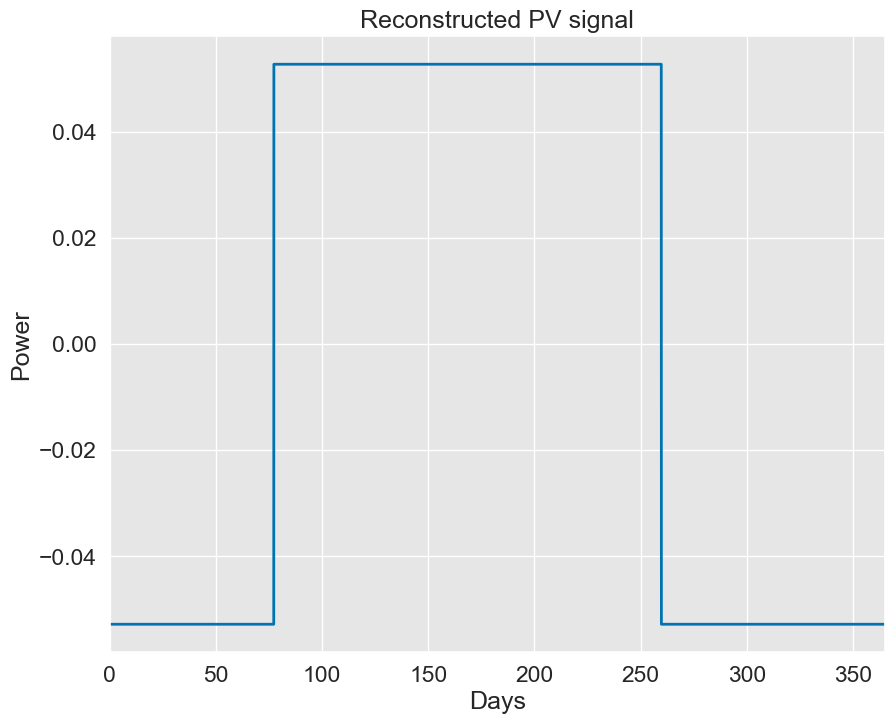

In [13]:
time_scales =  [24., 168., 8760.]

dpd = 24 # data per day
dpy = 365 # data per year :  cut the leap years to 365 years
# Options of the wavelet decomposition
vy = 1  # number of vectors per years (child wavelets)
vw = 1  # vectors per week
vd = 1  # vectors per day

# Signals can then be interpotated (within import_excel function)to a greater number of data per day (ndpd).This is useful for the wavelet decomposition to obtain daughter wavelets of th proper length.
ndpd = 64 # new data per year (for the interpolation). Minimum number so that the shortes wavelet has 2 data.
signal_length = ndpd * dpy


country_name = 'France'
folder = path_input_data + f'/{country_name}'
partie_name_file = f'grid_locations_averaged_pv_{country_name}_2021.xlsx' 
chemin_pattern = os.path.join(folder, f'*{partie_name_file}*')
fichiers_trouves = glob.glob(chemin_pattern)
if len(fichiers_trouves)!=0:
    file_name = fichiers_trouves[0].split('/',2)[-1]
    PV_ts = import_excel(path_input_data,file_name, 
                                    dpd ,ndpd, dpy, 
                                    interp=True, norm = None)
# Time scales of the wavelet decomposition
time_scales = [24., 168.,8760.] # cycles length, in hours

translation_name = f'{country_name}_PV_ninja'
translation_results_root = 'translation_calculation_results/' + translation_name 

path_trans = translation_results_root + '/translation/'
create_directory(path_trans)
path_matrix = translation_results_root + '/matrix/'
create_directory(path_matrix)

wl_shape = 'square' # 'square' or 'sine_function' : shape of the wavelet. Per default, choose square. The sine function is just here to play around.
input_data = PV_ts

# Get translation
trans = calc_all_translations_justine(path_trans, translation_name,
                                ndpd, dpy, input_data, wl_shape='square', 
                                recompute_translation= False)

beta_path = f'results_decomposition_coefficient/Plexos/{country_name}_PV/'
stacked_betas_pv, per_year_betas_pv = compute_wavelet_coefficient_betas(input_data,
            vy, vw, vd, dpy, ndpd,
            trans,
            path_matrix,
            beta_path, wl_shape ='square', imp_matrix = True,
            years = ['2015'])
year = '2015'

matrix_name = 'A_'+ year +'.npz'

A_sparse  = sparse.load_npz(path_matrix + matrix_name)
A = sparse.csr_matrix.todense(A_sparse)
matrix = np.asarray(A)

reconstructed_pv_year = reconstruct(time_scales, [
        8760.],
            matrix,per_year_betas_pv['2015'], "Reconstructed PV signal",
            xmin=0, xmax=365,
            dpy=365, dpd=64,
            add_offset=False, plot = True)


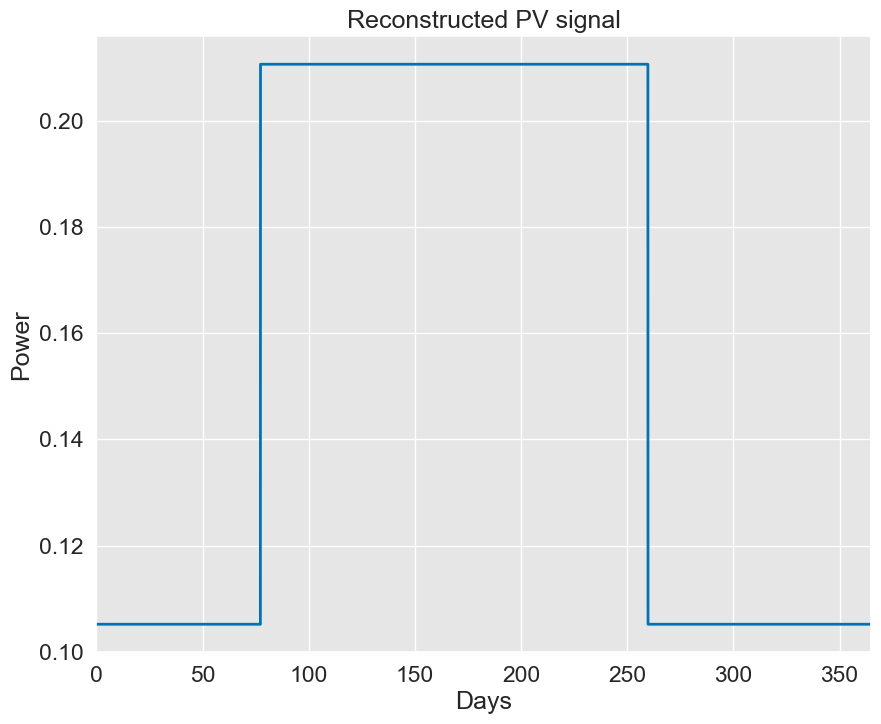

In [14]:
#Avec Offset
reconstructed_pv_year = reconstruct(time_scales, [
        8760.],
            matrix,per_year_betas_pv['2015'], "Reconstructed PV signal",
            xmin=0, xmax=365,
            dpy=365, dpd=64,
            add_offset=True, plot = True)

### Pays

In [32]:
time_scales =  [24., 168., 8760.]

dpd = 24 # data per day
dpy = 365 # data per year :  cut the leap years to 365 years
# Options of the wavelet decomposition
vy = 1  # number of vectors per years (child wavelets)
vw = 1  # vectors per week
vd = 1  # vectors per day

# Signals can then be interpotated (within import_excel function)to a greater number of data per day (ndpd).This is useful for the wavelet decomposition to obtain daughter wavelets of th proper length.
ndpd = 64 # new data per year (for the interpolation). Minimum number so that the shortes wavelet has 2 data.
signal_length = ndpd * dpy

# Insérer la suite dans une boucle

for country_name in countries[:]:
    try :
        print('Reconstruction PV '+ country_name + '...')
        # PV wavelets

        folder = path_input_data + f'/{country_name}'
        partie_name_file = f'grid_locations_averaged_pv_{country_name}_2021.xlsx' 
        chemin_pattern = os.path.join(folder, f'*{partie_name_file}*')
        fichiers_trouves = glob.glob(chemin_pattern)
        if len(fichiers_trouves)!=0:
            file_name = fichiers_trouves[0].split('/',2)[-1]
            PV_ts = import_excel(path_input_data,file_name, 
                                            dpd ,ndpd, dpy, 
                                            interp=True, norm = None) # interpolate data from dpd to ndpd numper of points per day

        # Time scales of the wavelet decomposition
        time_scales = [24., 168.,8760.] # cycles length, in hours

        translation_name = f'{country_name}_PV_ninja'
        translation_results_root = 'translation_calculation_results/' + translation_name 

        path_trans = translation_results_root + '/translation/'
        create_directory(path_trans)
        path_matrix = translation_results_root + '/matrix/'
        create_directory(path_matrix)

        wl_shape = 'square' # 'square' or 'sine_function' : shape of the wavelet. Per default, choose square. The sine function is just here to play around.
        input_data = PV_ts

        # Get translation
        trans = calc_all_translations_justine(path_trans, translation_name,
                                        ndpd, dpy, input_data, wl_shape='square', 
                                        recompute_translation= False)

        beta_path = f'results_decomposition_coefficient/Plexos/{country_name}_PV/'
        stacked_betas_pv, per_year_betas_pv = compute_wavelet_coefficient_betas(input_data,
                    vy, vw, vd, dpy, ndpd,
                    trans,
                    path_matrix,
                    beta_path, wl_shape ='square', imp_matrix = True,
                    years = ['2015'])
        year = '2015'

        matrix_name = 'A_'+ year +'.npz'

        A_sparse  = sparse.load_npz(path_matrix + matrix_name)
        A = sparse.csr_matrix.todense(A_sparse)
        matrix = np.asarray(A)
        
        reconstructed_pv_year = reconstruct(time_scales, [
                8760.],
                    matrix,per_year_betas_pv['2015'], "Reconstructed PV signal",
                    xmin=0, xmax=365,
                    dpy=365, dpd=64,
                    add_offset=False, plot = False)

        reconstructed_pv_week = reconstruct(time_scales, [
                168.],
                    matrix,per_year_betas_pv['2015'], "Reconstructed PV signal",
                    xmin=0, xmax=365,
                    dpy=365, dpd=64,
                    add_offset=False, plot = False)
        
        reconstructed_pv_day = reconstruct(time_scales, [
                24.],
                    matrix,per_year_betas_pv['2015'], "Reconstructed PV signal",
                    xmin=0, xmax=365,
                    dpy=365, dpd=64,
                    add_offset=False, plot = False)

        print('Reconstruction Wind '+ country_name + '...')
        #-------------------------------- Wind wavelets ---------------------------------------------------

        folder = path_input_data + f'/{country_name}'
        partie_name_file = f'grid_locations_averaged_wind_{country_name}_2021.xlsx' 
        chemin_pattern = os.path.join(folder, f'*{partie_name_file}*')
        fichiers_trouves = glob.glob(chemin_pattern)
        if len(fichiers_trouves)!=0:
            file_name = fichiers_trouves[0].split('/',2)[-1]
            Wind_ts = import_excel(path_input_data,file_name, 
                                            dpd ,ndpd, dpy, 
                                            interp=True, norm = None) # interpolate data from dpd to ndpd numper of points per day
        # Time scales of the wavelet decomposition
        time_scales = [24., 168.,8760.] # cycles length, in hours

        translation_name = f'{country_name}_Wind_ninja'
        translation_results_root = 'translation_calculation_results/' + translation_name 

        path_trans = translation_results_root + '/translation/'
        create_directory(path_trans)
        path_matrix = translation_results_root + '/matrix/'
        create_directory(path_matrix)

        wl_shape = 'square' # 'square' or 'sine_function' : shape of the wavelet. Per default, choose square. The sine function is just here to play around.
        input_data = Wind_ts

        # Get translation
        trans = calc_all_translations_justine(path_trans, translation_name,
                                        ndpd, dpy, input_data, wl_shape='square', 
                                        recompute_translation= False)

        beta_path = f'results_decomposition_coefficient/Plexos/{country_name}_Wind/'
        stacked_betas_wind, per_year_betas_wind = compute_wavelet_coefficient_betas(input_data,
                    vy, vw, vd, dpy, ndpd,
                    trans,
                    path_matrix,
                    beta_path, wl_shape ='square', imp_matrix = True,
                    years = ['2015'])
        year = '2015'

        matrix_name = 'A_'+ year +'.npz'

        A_sparse  = sparse.load_npz(path_matrix + matrix_name)
        A = sparse.csr_matrix.todense(A_sparse)
        matrix = np.asarray(A)
        
        reconstructed_wind_year = reconstruct(time_scales, [
                8760.],
                    matrix,per_year_betas_wind['2015'], "Reconstructed Wind signal",
                    xmin=0, xmax=365,
                    dpy=365, dpd=64,
                    add_offset=False, plot = False)

        reconstructed_wind_week = reconstruct(time_scales, [
                168.],
                    matrix,per_year_betas_wind['2015'], "Reconstructed Wind signal",
                    xmin=0, xmax=365,
                    dpy=365, dpd=64,
                    add_offset=False, plot = False)
        
        reconstructed_wind_day = reconstruct(time_scales, [
                24.],
                    matrix,per_year_betas_wind['2015'], "Reconstructed Wind signal",
                    xmin=0, xmax=365,
                    dpy=365, dpd=64,
                    add_offset=False, plot = False)
        
        print('Reconstruction Load '+ country_name + '...')
        #-------------------------------- Load wavelets ---------------------------------------------------
        vy = 1  # number of vectors per years (child wavelets)
        vw = 1  # vectors per week
        vd = 1  
          # vectors per day
        file_name = format_load_data(country_name)
        Load_ts = import_excel(path_input_data,file_name, 
                                        dpd ,ndpd, dpy, 
                                        interp=True, norm = 'mean')
        # interpolate data from dpd to ndpd numper of points per day

        # Time scales of the wavelet decomposition
        time_scales = [24., 168.,8760.] # cycles length, in hours

        translation_name = f'{country_name}_PLEXOS_bis'
        translation_results_root = 'translation_calculation_results/' + translation_name 

        path_trans = translation_results_root + '/translation/'
        create_directory(path_trans)
        path_matrix = translation_results_root + '/matrix/'
        create_directory(path_matrix)

        wl_shape = 'square' # 'square' or 'sine_function' : shape of the wavelet. Per default, choose square. The sine function is just here to play around.
        input_data = Load_ts

        # Get translation
        trans = calc_all_translations_justine(path_trans, translation_name,
                                        ndpd, dpy, input_data, wl_shape='square', 
                                        recompute_translation= False)

        beta_path = f'results_decomposition_coefficient/PLEXOS_new/{country_name}/'
        stacked_betas_load, per_year_betas_load = compute_wavelet_coefficient_betas(input_data,
                    vy, vw, vd, dpy, ndpd,
                    trans,
                    path_matrix,
                    beta_path, wl_shape ='square', imp_matrix = True,
                    years = ['2015'])
        year = '2015'

        matrix_name = 'A_'+ year +'.npz'

        A_sparse  = sparse.load_npz(path_matrix + matrix_name)
        A = sparse.csr_matrix.todense(A_sparse)
        matrix = np.asarray(A)
        print(len(matrix))
        print(len(per_year_betas_load['2015'][0]))
        reconstructed_load_year = reconstruct(time_scales, [
                8760.],
                    matrix,per_year_betas_load['2015'], "Reconstructed Load signal",
                    xmin=0, xmax=365,
                    dpy=365, dpd=64,
                    add_offset=False, plot = False)
        reconstructed_load_week = reconstruct(time_scales, [
                168.],
                    matrix,per_year_betas_load['2015'], "Reconstructed Load signal",
                    xmin=0, xmax=365,
                    dpy=365, dpd=64,
                    add_offset=False, plot = False)
        
        reconstructed_load_day = reconstruct(time_scales, [
                24.],
                    matrix,per_year_betas_load['2015'], "Reconstructed Load signal",
                    xmin=0, xmax=365,
                    dpy=365, dpd=64,
                    add_offset=False, plot = False)
        print('load done')

        results = {'pv_year':reconstructed_pv_year, 
                'pv_day':reconstructed_pv_day, 
                'pv_week':reconstructed_pv_week,
                    'wind_year':reconstructed_wind_year, 
                'wind_day':reconstructed_wind_day, 
                'wind_week':reconstructed_wind_week,
                    'load_year':reconstructed_load_year, 
                'load_day':reconstructed_load_day, 
                'load_week':reconstructed_load_week}
        filename = f'results_decomposition_coefficient/Plexos/wavelets_reconstruction/wavelets_{country_name}.pickle'
        
        if not os.path.exists('results_decomposition_coefficient/Plexos/wavelets_reconstruction/'):
                os.makedirs('results_decomposition_coefficient/Plexos/wavelets_reconstruction/')
        with open(filename, 'wb') as pickle_file:
                pickle.dump(results, pickle_file)

        print(f"Wavelets results saved to "+filename)
    except Exception as e:
        print(f"Error for {country_name}: {e}")


Reconstruction PV Afghanistan...


Directory 'translation_calculation_results/Afghanistan_PV_ninja/translation/' already exists.
Directory 'translation_calculation_results/Afghanistan_PV_ninja/matrix/' already exists.
Loading existing translation file: s:\131-DPE\131.1-Temporaire\131.1.1-Espace commun\zone transfert temporaire\ITESE Grenoble\Stage Justine\Code git\wavelet_decomposition\optim_mix\translation_calculation_results/Afghanistan_PV_ninja/translation/results_translation_justine_Afghanistan_PV_ninja.pkl
Directory 'results_decomposition_coefficient/Plexos/Afghanistan_PV/' already exists.
translation_calculation_results/Afghanistan_PV_ninja/matrix/A_2015.npz
[[3, 195, 8067]]
Importing matrix A square
Square sparsee matrix or year 2015 has been imported
Reconstruction Wind Afghanistan...
Directory 'translation_calculation_results/Afghanistan_Wind_ninja/translation/' already exists.
Directory 'translation_calculation_results/Afghanistan_Wind_ninja/matrix/' already exists.
Loading existing translation file: s:\131-DP

### Etats

On est obligé de réutiliser les fonctions de calcul des translations et des amplitudes des ondelettes pour récupérer les bonnes valeurs.
A terme, il faudrait écrire une fonction permettant de lire directement les résultats des calculs de la décomposition.

In [33]:
time_scales =  [24., 168., 8760.]

dpd = 24 # data per day
dpy = 365 # data per year :  cut the leap years to 365 years
# Options of the wavelet decomposition
vy = 1  # number of vectors per years (child wavelets)
vw = 1  # vectors per week
vd = 1  # vectors per day

# Signals can then be interpotated (within import_excel function)to a greater number of data per day (ndpd).This is useful for the wavelet decomposition to obtain daughter wavelets of th proper length.
ndpd = 64 # new data per year (for the interpolation). Minimum number so that the shortes wavelet has 2 data.
signal_length = ndpd * dpy

# Insérer la suite dans une boucle

for country_name in ['Australia', 'United States', 'Brazil', 'Canada', 'China', 'Russia']: 
# for country_name in ['Russia']: 
    regions_match = pd.read_excel('match_plexos_iso_codes.xlsx')
    regions_match = regions_match[regions_match['Country']==country_name].set_index('region')
    dic_states = dict_list[country_name]
    for state in dic_states:
        try :
            print('Reconstruction PV '+ country_name + state + '...')
            # PV wavelets
            region_name = regions_match.loc[state, 'plexos']
            folder = path_input_data + f'/{country_name}'

            partie_name_file = f'grid_locations_averaged_pv_{country_name}_{state}_2021.xlsx' 

            chemin_pattern = os.path.join(folder, f'*{partie_name_file}*')
            fichiers_trouves = glob.glob(chemin_pattern)

            if len(fichiers_trouves)!=0:
                file_name = fichiers_trouves[0].split('/',2)[-1]
                PV_ts = import_excel(path_input_data,file_name, 
                                                dpd ,ndpd, dpy, 
                                                interp=True, norm = None) 
            
                # Options of the wavelet decomposition
                vy = 1  # number of vectors per years (child wavelets)
                vw = 1  # vectors per week
                vd = 1  # vectors per day

                # Time scales of the wavelet decomposition
                time_scales = [24., 168., 8760.] # cycles length, in hours

                translation_name = f'{country_name}_{state}_PV_ninja'
                translation_results_root = 'translation_calculation_results/' + translation_name 

                path_trans = translation_results_root + '/translation/'
                create_directory(path_trans)
                path_matrix = translation_results_root + '/matrix/'
                create_directory(path_matrix)

                wl_shape = 'square' # 'square' or 'sine_function' : shape of the wavelet. Per default, choose square. The sine function is just here to play around.
                input_data = PV_ts
        
                # Get translation
                trans = calc_all_translations_justine(path_trans, translation_name,
                                                ndpd, dpy, input_data, wl_shape='square', 
                                                recompute_translation= False)

                beta_path = f'results_decomposition_coefficient/Plexos/{country_name}_{state}_PV_ninja/'
                stacked_betas_pv, per_year_betas_pv = compute_wavelet_coefficient_betas(input_data,
                            vy, vw, vd, dpy, ndpd,
                            trans,
                            path_matrix,
                            beta_path, wl_shape ='square', imp_matrix = True,
                            years = ['2015'])
                year = '2015'

                matrix_name = 'A_'+ year +'.npz'

                A_sparse  = sparse.load_npz(path_matrix + matrix_name)
                A = sparse.csr_matrix.todense(A_sparse)
                matrix = np.asarray(A)
                
                reconstructed_pv_year = reconstruct(time_scales, [
                        8760.],
                            matrix,per_year_betas_pv['2015'], "Reconstructed PV signal",
                            xmin=0, xmax=365,
                            dpy=365, dpd=64,
                            add_offset=False, plot = False)

                reconstructed_pv_week = reconstruct(time_scales, [
                        168.],
                            matrix,per_year_betas_pv['2015'], "Reconstructed PV signal",
                            xmin=0, xmax=365,
                            dpy=365, dpd=64,
                            add_offset=False, plot = False)
                
                reconstructed_pv_day = reconstruct(time_scales, [
                        24.],
                            matrix,per_year_betas_pv['2015'], "Reconstructed PV signal",
                            xmin=0, xmax=365,
                            dpy=365, dpd=64,
                            add_offset=False, plot = False)

                print('Reconstruction Wind '+ country_name + '...')
            #-------------------------------- Wind wavelets ---------------------------------------------------

                folder = path_input_data + f'/{country_name}'
                partie_name_file = f'grid_locations_averaged_wind_{country_name}_{state}_2021.xlsx' 
                chemin_pattern = os.path.join(folder, f'*{partie_name_file}*')
                fichiers_trouves = glob.glob(chemin_pattern)
                if len(fichiers_trouves)!=0:
                    file_name = fichiers_trouves[0].split('/',2)[-1]
                    Wind_ts = import_excel(path_input_data,file_name, 
                                                    dpd ,ndpd, dpy, 
                                                    interp=True, norm = None) # interpolate data from dpd to ndpd numper of points per day
                # Time scales of the wavelet decomposition
                time_scales = [24., 168.,8760.] # cycles length, in hours

                translation_name = f'{country_name}_{state}_Wind_ninja'
                translation_results_root = 'translation_calculation_results/' + translation_name 

                path_trans = translation_results_root + '/translation/'
                create_directory(path_trans)
                path_matrix = translation_results_root + '/matrix/'
                create_directory(path_matrix)

                wl_shape = 'square' # 'square' or 'sine_function' : shape of the wavelet. Per default, choose square. The sine function is just here to play around.
                input_data = Wind_ts

                # Get translation
                trans = calc_all_translations_justine(path_trans, translation_name,
                                                ndpd, dpy, input_data, wl_shape='square', 
                                                recompute_translation= False)

                beta_path = f'results_decomposition_coefficient/Plexos/{country_name}_{state}_Wind_ninja/'
                stacked_betas_wind, per_year_betas_wind = compute_wavelet_coefficient_betas(input_data,
                            vy, vw, vd, dpy, ndpd,
                            trans,
                            path_matrix,
                            beta_path, wl_shape ='square', imp_matrix = True,
                            years = ['2015'])
                year = '2015'

                matrix_name = 'A_'+ year +'.npz'

                A_sparse  = sparse.load_npz(path_matrix + matrix_name)
                A = sparse.csr_matrix.todense(A_sparse)
                matrix = np.asarray(A)
                
                reconstructed_wind_year = reconstruct(time_scales, [
                        8760.],
                            matrix,per_year_betas_wind['2015'], "Reconstructed Wind signal",
                            xmin=0, xmax=365,
                            dpy=365, dpd=64,
                            add_offset=False, plot = False)

                reconstructed_wind_week = reconstruct(time_scales, [
                        168.],
                            matrix,per_year_betas_wind['2015'], "Reconstructed Wind signal",
                            xmin=0, xmax=365,
                            dpy=365, dpd=64,
                            add_offset=False, plot = False)
                
                reconstructed_wind_day = reconstruct(time_scales, [
                        24.],
                            matrix,per_year_betas_wind['2015'], "Reconstructed Wind signal",
                            xmin=0, xmax=365,
                            dpy=365, dpd=64,
                            add_offset=False, plot = False)
                
                print('Reconstruction Load '+ country_name + '...')
                #-------------------------------- Load wavelets ---------------------------------------------------
                vy = 1  # number of vectors per years (child wavelets)
                vw = 1  # vectors per week
                vd = 1  
                # vectors per day
                file_name = format_load_data(country_name, state_name=region_name)
                Load_ts = import_excel(path_input_data,file_name, 
                                                dpd ,ndpd, dpy, 
                                                interp=True, norm = 'mean')
                # interpolate data from dpd to ndpd numper of points per day

                # Time scales of the wavelet decomposition
                time_scales = [24., 168.,8760.] # cycles length, in hours

                translation_name = f'{country_name}_{region_name}_PLEXOS'
                translation_results_root = 'translation_calculation_results/' + translation_name 

                path_trans = translation_results_root + '/translation/'
                create_directory(path_trans)
                path_matrix = translation_results_root + '/matrix/'
                create_directory(path_matrix)

                wl_shape = 'square' # 'square' or 'sine_function' : shape of the wavelet. Per default, choose square. The sine function is just here to play around.
                input_data = Load_ts

                # Get translation
                trans = calc_all_translations_justine(path_trans, translation_name,
                                                ndpd, dpy, input_data, wl_shape='square', 
                                                recompute_translation= False)

                beta_path = f'results_decomposition_coefficient/PLEXOS_new/{country_name}_{region_name}/'
                stacked_betas_load, per_year_betas_load = compute_wavelet_coefficient_betas(input_data,
                            vy, vw, vd, dpy, ndpd,
                            trans,
                            path_matrix,
                            beta_path, wl_shape ='square', imp_matrix = True,
                            years = ['2015'])
                year = '2015'

                matrix_name = 'A_'+ year +'.npz'

                A_sparse  = sparse.load_npz(path_matrix + matrix_name)
                A = sparse.csr_matrix.todense(A_sparse)
                matrix = np.asarray(A)

                reconstructed_load_year = reconstruct(time_scales, [
                        8760.],
                            matrix,per_year_betas_load['2015'], "Reconstructed Load signal",
                            xmin=0, xmax=365,
                            dpy=365, dpd=64,
                            add_offset=False, plot = False)
                reconstructed_load_week = reconstruct(time_scales, [
                        168.],
                            matrix,per_year_betas_load['2015'], "Reconstructed Load signal",
                            xmin=0, xmax=365,
                            dpy=365, dpd=64,
                            add_offset=False, plot = False)
                
                reconstructed_load_day = reconstruct(time_scales, [
                        24.],
                            matrix,per_year_betas_load['2015'], "Reconstructed Load signal",
                            xmin=0, xmax=365,
                            dpy=365, dpd=64,
                            add_offset=False, plot = False)
                print('load done')

                results = {'pv_year':reconstructed_pv_year, 
                        'pv_day':reconstructed_pv_day, 
                        'pv_week':reconstructed_pv_week,
                            'wind_year':reconstructed_wind_year, 
                        'wind_day':reconstructed_wind_day, 
                        'wind_week':reconstructed_wind_week,
                            'load_year':reconstructed_load_year, 
                        'load_day':reconstructed_load_day, 
                        'load_week':reconstructed_load_week}
                filename = f'results_decomposition_coefficient/Plexos/wavelets_reconstruction/wavelets_{country_name}_{state}.pickle'
                
                if not os.path.exists('results_decomposition_coefficient/Plexos/wavelets_reconstruction/'):
                        os.makedirs('results_decomposition_coefficient/Plexos/wavelets_reconstruction/')
                with open(filename, 'wb') as pickle_file:
                        pickle.dump(results, pickle_file)

                print(f"Wavelets results saved to "+filename)
        except Exception as e:
            print(f"Error for {country_name} and {state}: {e}")


Reconstruction PV AustraliaNSW...
Directory 'translation_calculation_results/Australia_NSW_PV_ninja/translation/' already exists.
Directory 'translation_calculation_results/Australia_NSW_PV_ninja/matrix/' already exists.
Loading existing translation file: s:\131-DPE\131.1-Temporaire\131.1.1-Espace commun\zone transfert temporaire\ITESE Grenoble\Stage Justine\Code git\wavelet_decomposition\optim_mix\translation_calculation_results/Australia_NSW_PV_ninja/translation/results_translation_justine_Australia_NSW_PV_ninja.pkl
Directory 'results_decomposition_coefficient/Plexos/Australia_NSW_PV_ninja/' already exists.
translation_calculation_results/Australia_NSW_PV_ninja/matrix/A_2015.npz
[[53, 53, 15798]]
Importing matrix A square
Square sparsee matrix or year 2015 has been imported
Reconstruction Wind Australia...
Directory 'translation_calculation_results/Australia_NSW_Wind_ninja/translation/' already exists.
Directory 'translation_calculation_results/Australia_NSW_Wind_ninja/matrix/' alrea

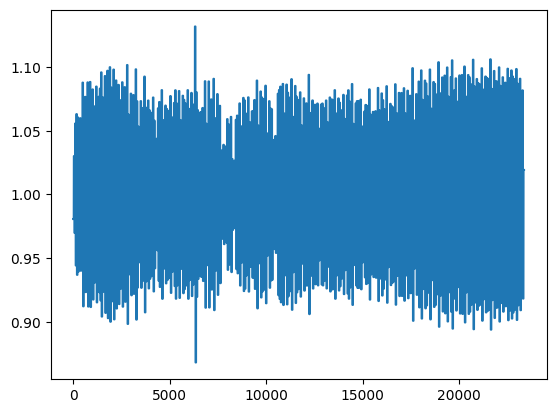

In [14]:
plt.plot(reconstructed_load_day)

# Calcul des produits scalaires entre les ondelettes

### Visualisation des ondelettes

In [36]:
country_name = 'Djibouti'
wavelets = pd.read_pickle(f'results_decomposition_coefficient/Plexos/wavelets_reconstruction/wavelets_{country_name}.pickle')
file_name = format_load_data(country_name)
Load_ts = import_excel(path_input_data,file_name, 
                                dpd ,ndpd, dpy, 
                                interp=True, norm = 'mean')

In [37]:
wavelets

{'pv_year': array([0.0389213, 0.0389213, 0.0389213, ..., 0.0389213, 0.0389213,
        0.0389213]),
 'pv_day': array([-0.23639648, -0.23639648, -0.23639648, ..., -0.23639648,
        -0.23639648, -0.23639648]),
 'pv_week': array([-0.00063249, -0.00063249, -0.00063249, ..., -0.00063249,
        -0.00063249, -0.00063249]),
 'wind_year': array([0.11421633, 0.11421633, 0.11421633, ..., 0.11421633, 0.11421633,
        0.11421633]),
 'wind_day': array([0.09444505, 0.09444505, 0.09444505, ..., 0.09444505, 0.09444505,
        0.09444505]),
 'wind_week': array([0., 0., 0., ..., 0., 0., 0.]),
 'load_year': array([-0.26120156, -0.26120156, -0.26120156, ..., -0.26120156,
        -0.26120156, -0.26120156]),
 'load_day': array([-0.06575004, -0.06575004, -0.06575004, ..., -0.06575004,
        -0.06575004, -0.06575004]),
 'load_week': array([0.02089623, 0.02089623, 0.02089623, ..., 0.02089623, 0.02089623,
        0.02089623]),
 'scalar_year_pv_load': -236.63089539001916,
 'scalar_week_pv_load': -0.832

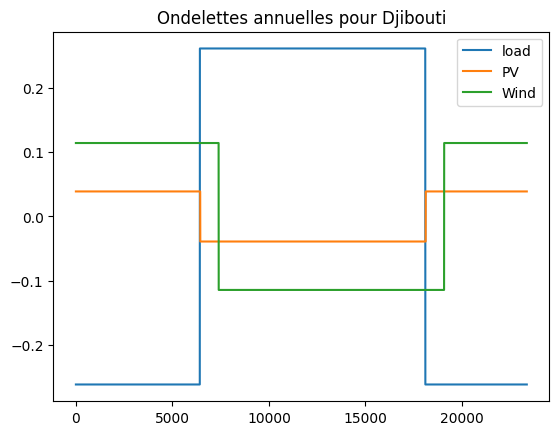

In [38]:
plt.plot(wavelets['load_year'], label = 'load')
plt.plot(wavelets['pv_year'], label= 'PV')
plt.plot(wavelets['wind_year'], label = 'Wind')
plt.title(f'Ondelettes annuelles pour {country_name}')
plt.legend()
plt.show()

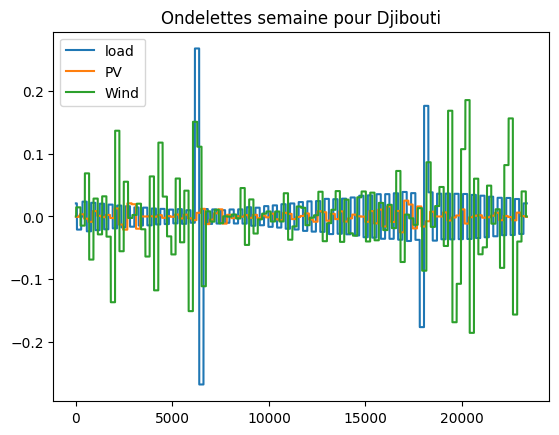

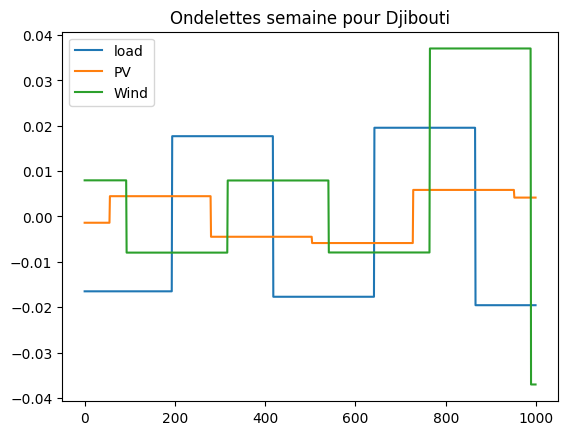

In [39]:
plt.plot(wavelets['load_week'], label = 'load')
plt.plot(wavelets['pv_week'], label= 'PV')
plt.plot(wavelets['wind_week'], label = 'Wind')
plt.title(f'Ondelettes semaine pour {country_name}')
plt.legend()
plt.show()
#Zoom
plt.plot(wavelets['load_week'][10000:11000], label = 'load')
plt.plot(wavelets['pv_week'][10000:11000], label= 'PV')
plt.plot(wavelets['wind_week'][10000:11000], label = 'Wind')
plt.title(f'Ondelettes semaine pour {country_name}')
plt.legend()
plt.show()

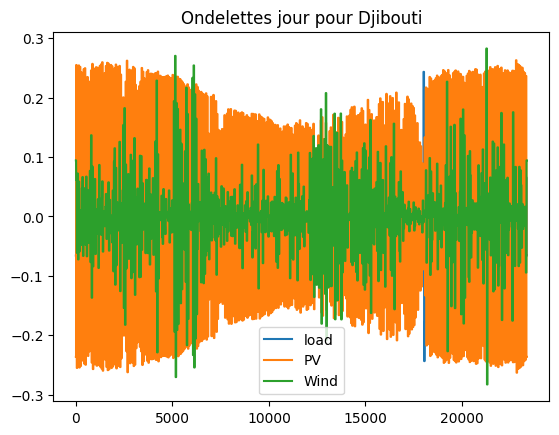

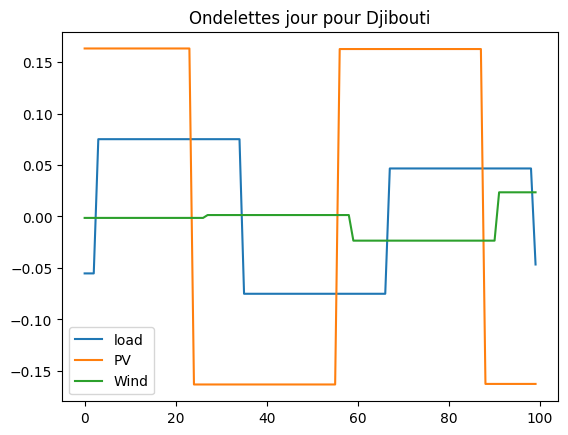

In [40]:
plt.plot(wavelets['load_day'], label = 'load')
plt.plot(wavelets['pv_day'], label= 'PV')
plt.plot(wavelets['wind_day'], label = 'Wind')
plt.title(f'Ondelettes jour pour {country_name}')
plt.legend()
plt.show()
#Zoom
plt.plot(wavelets['load_day'][10000:10100], label = 'load')
plt.plot(wavelets['pv_day'][10000:10100], label= 'PV')
plt.plot(wavelets['wind_day'][10000:10100], label = 'Wind')
plt.title(f'Ondelettes jour pour {country_name}')
plt.legend()
plt.show()

In [38]:
for country_name in countries[:]:
    wavelets = pd.read_pickle(f'results_decomposition_coefficient/Plexos/wavelets_reconstruction/wavelets_{country_name}.pickle')
    scalar_year_pv = np.dot(wavelets['pv_year'], wavelets['load_year'])
    scalar_year_wind = np.dot(wavelets['wind_year'], wavelets['load_year'])
    scalar_day_pv = np.dot(wavelets['pv_day'], wavelets['load_day'])
    scalar_day_wind = np.dot(wavelets['wind_day'], wavelets['load_day'])
    scalar_week_pv = np.dot(wavelets['pv_week'], wavelets['load_week'])
    scalar_week_wind = np.dot(wavelets['wind_week'], wavelets['load_week'])
    wavelets['scalar_year_pv_load']=scalar_year_pv
    wavelets['scalar_week_pv_load']=scalar_week_pv
    wavelets['scalar_day_pv_load']=scalar_day_pv
    wavelets['scalar_year_wind_load']=scalar_year_wind
    wavelets['scalar_week_wind_load']=scalar_week_wind
    wavelets['scalar_day_wind_load']=scalar_day_wind
    filename = f'results_decomposition_coefficient/Plexos/wavelets_reconstruction/wavelets_{country_name}.pickle'
    
    with open(filename, 'wb') as pickle_file:
            pickle.dump(wavelets, pickle_file)

    

In [39]:
for country_name in ['Australia', 'United States', 'Brazil', 'Canada', 'China', 'Russia']: 
# for country_name in [ 'Russia']: 

        
# for country_name in ['Australia']: 
        regions_match = pd.read_excel('match_plexos_iso_codes.xlsx')
        regions_match = regions_match[regions_match['Country']==country_name].set_index('region')
        dic_states = dict_list[country_name]
        for state in dic_states:
            try:
                # print(state)
                wavelets = pd.read_pickle(f'results_decomposition_coefficient/Plexos/wavelets_reconstruction/wavelets_{country_name}_{state}.pickle')
                scalar_year_pv = np.dot(wavelets['pv_year'], wavelets['load_year'])
                scalar_year_wind = np.dot(wavelets['wind_year'], wavelets['load_year'])
                scalar_day_pv = np.dot(wavelets['pv_day'], wavelets['load_day'])
                scalar_day_wind = np.dot(wavelets['wind_day'], wavelets['load_day'])
                scalar_week_pv = np.dot(wavelets['pv_week'], wavelets['load_week'])
                scalar_week_wind = np.dot(wavelets['wind_week'], wavelets['load_week'])
                wavelets['scalar_year_pv_load']=scalar_year_pv
                wavelets['scalar_week_pv_load']=scalar_week_pv
                wavelets['scalar_day_pv_load']=scalar_day_pv
                wavelets['scalar_year_wind_load']=scalar_year_wind
                wavelets['scalar_week_wind_load']=scalar_week_wind
                wavelets['scalar_day_wind_load']=scalar_day_wind
                filename = f'results_decomposition_coefficient/Plexos/wavelets_reconstruction/wavelets_{country_name}_{state}.pickle'
                
                with open(filename, 'wb') as pickle_file:
                        pickle.dump(wavelets, pickle_file)
            except Exception as e:
                print(f"Error for {country_name} and {state}: {e}")

Error for United States and HI: [Errno 2] No such file or directory: 'results_decomposition_coefficient/Plexos/wavelets_reconstruction/wavelets_United States_HI.pickle'
Error for Russia and ARK: [Errno 2] No such file or directory: 'results_decomposition_coefficient/Plexos/wavelets_reconstruction/wavelets_Russia_ARK.pickle'
Error for Russia and KAM: [Errno 2] No such file or directory: 'results_decomposition_coefficient/Plexos/wavelets_reconstruction/wavelets_Russia_KAM.pickle'
Error for Russia and KHA: [Errno 2] No such file or directory: 'results_decomposition_coefficient/Plexos/wavelets_reconstruction/wavelets_Russia_KHA.pickle'


In [40]:
result = pd.read_pickle(f'results_decomposition_coefficient/Plexos/wavelets_reconstruction/wavelets_United States_CA.pickle')

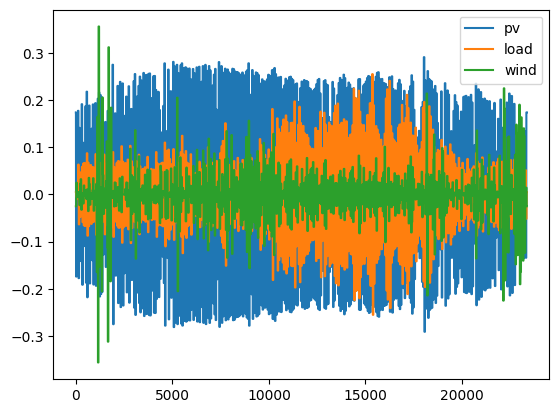

In [41]:
plt.plot(result['pv_day'], label = 'pv')
plt.plot(result['load_day'], label = 'load')
plt.plot(result['wind_day'], label = 'wind')
plt.legend()